## Summary
Try using XGBoost to predict loss. From Kaggle forum [post](https://www.kaggle.com/iglovikov/allstate-claims-severity/xgb-1114).

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [2]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(os.path.join(loc,'train.csv'))
train.drop('id',axis=1,inplace=True)

test = pd.read_csv(os.path.join(loc,'test.csv'))
ids = test['id']
test.drop('id',axis=1,inplace=True)

submission = pd.read_csv(os.path.join(loc,"sample_submission.csv"))

In [3]:
import xgboost as xgb

In [4]:
def convert_strings(pdseries):
    # Function inputs a column of a pandas DataFrame,
    # determines the number of unique entries, and assigns 
    # an integer to each entry. 
    # This is to avoid issues with non-integer data.
      
    array = np.array(pdseries)
    vals = np.unique(array)
    nums = np.arange(0,len(vals),1)
    #new_array = np.zeros(len(array),dtype='int')     
    new_array = np.zeros(len(array),dtype='float')
    
    #nums = np.linspace(0,1,len(vals))
    #new_array = np.zeros(len(array))

    for j in range(len(vals)):
        ind = np.where(array==vals[j])[0]
        new_array[ind]=nums[j]
     
    # Returns a numpy array with an integer for each entry
    return new_array

In [6]:
y = np.log1p(train['loss'].values)
full = pd.concat([train,test],ignore_index=True)
full = full.drop('loss',axis=1)
full.head()
to_remove = list(['cont1','cont11','cont6','cat2','cat6','cat8','cat7','cat16'])

for col in full.columns:
    if 'cat' in col:
        full.loc[:,col]=convert_strings(full.loc[:,col])
        

        
somefull = deepcopy(full)
for l in to_remove:
    somefull.drop(l,axis=1,inplace=True)
    
somefull.loc[:,'cont10']=np.log1p(somefull.loc[:,'cont10'])

1134.73719522


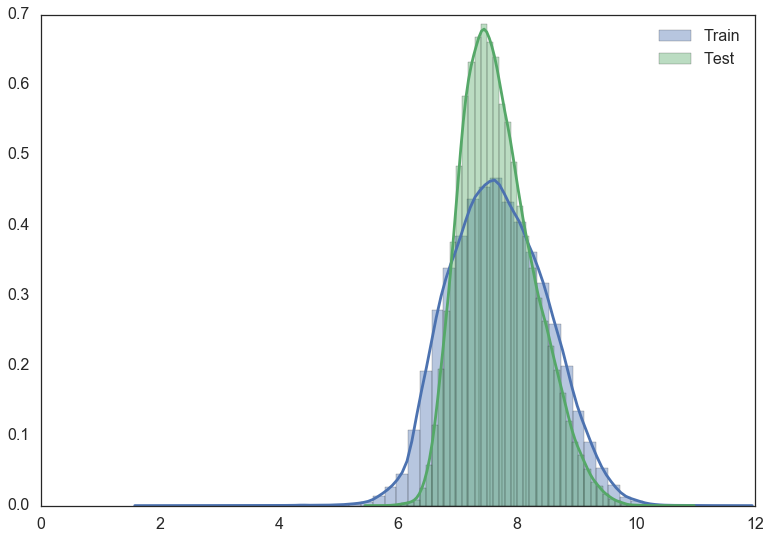

In [9]:
params = {
        'min_child_weight': 1,
        'eta': 0.01,
        'colsample_bytree': 0.5,
        'max_depth': 12,
        'subsample': 0.8,
        'alpha': 1,
        'gamma': 1,
        'silent': 1,
        'verbose_eval': True,
        'seed': 2016
    }


X_train, X_test, y_train, y_test = train_test_split(somefull[0:len(train)], y, test_size=.4)

xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest = xgb.DMatrix(X_test)

model = xgb.train(params, xgtrain, int(2012 / 0.9))

print mean_absolute_error(np.expm1(y_test),np.expm1(model.predict(xgtest)))

sns.set_context('poster')
sns.set_style('white')
sns.distplot(y_train,label='Train')
sns.distplot(model.predict(xgtest),label='Test')
plt.legend(loc='best')

In [11]:
xgtrain = xgb.DMatrix(somefull[0:len(train)], label=y)
xgtest = xgb.DMatrix(somefull[len(train):])

model = xgb.train(params, xgtrain, int(2012 / 0.9))
submission.iloc[:, 1] = np.expm1(model.predict(xgtest))
submission.to_csv(loc+'xgboost1.csv',index=False)
print 'Done'

Done


Try only using a handful of features:

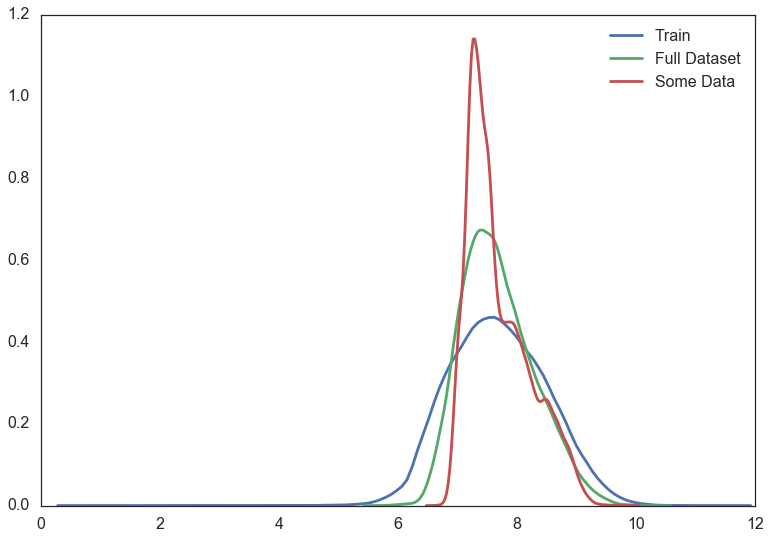

In [12]:
important = list(["cont10","cat1","cat3","cat4","cat9",
                  "cat10","cat12","cat27","cat35","cat37",
                  "cat59","cat66","cat69","cat71","cat79",
                  "cat80","cat81","cat83"])

keep_df = somefull[important]

X_train, X_test, y_train, y_test = train_test_split(keep_df[0:len(train)], y, test_size=.4)

xgtrain2 = xgb.DMatrix(X_train, label=y_train)
xgtest2 = xgb.DMatrix(X_test)

model2 = xgb.train(params, xgtrain2, int(2012 / 0.9))
sns.set_context('poster')
sns.set_style('white')
sns.distplot(y,label='Train',hist=False)
sns.distplot(model.predict(xgtest),label='Full Dataset',hist=False)
sns.distplot(model2.predict(xgtest2),label='Some Data',hist=False)
plt.legend(loc='best')